The main aim of this project is to build a distributed matrix factorization model, it was realized as a part of my studies at ENSAE.

This project is based on the paper [CuMF_SGD: Fast and Scalable Matrix Factorization](https://arxiv.org/abs/1610.05838).

This project was realized on google colaboratory for simplicity : using cython can be tedious on normal interpretors since it is necessary to save cythonized functions in separate files.



The CPU offered by colab only has 2 cores, therefore the benefits of distibuting matrix factorization on CPU is only slightly visible. This is especially true as cython first compiles the code to C++ which is much faster, which means that the benefits of distributing matrix factorization might be overshadowed by the benefits of compiling the code to C++.

In [ ]:
#@title Count number of CPUs
import multiprocessing
cores = multiprocessing.cpu_count() 
print("The CPU has",cores,"cores.")

The CPU has 2 cores.


---------

Matrix Factorization is a matrix completion technique. Matrix completion techniques aim to reconstruct a whole matrix M using only a few measures of coming from this matrix.

The idea of Matrix factorization is build two low ranks matrixes $P$ and $Q$ such that $M \approx P*Q$.

We first randomly initialize $P$ and $Q$, and update their coordinates using $SGD$.


The ($SGD$) loss used in this model is a normalized version the root mean square error : given $M,P$ and $Q$ and two integers $i$ and $j$, the error at coordinate $(i,j)$ is given by :

$err(i,j) = (M_{i,j}-\langle P_{i,.},Q_{.,j}\rangle)^{2} + \alpha \|P_{i,.}\|_{2}^{2} + \beta \|Q_{.,j}\|_{2}^{2}$

Where $P_{i,.}$ denotes the $i-th$ row of $P$, $Q_{.,j}$ denotes the $j-th$ column of Q, $\alpha$ and $\beta$ are two regularization parameters and $\langle , \rangle$ denotes the usual dot product.

---------

Python makes use of the GIL, a mutex lock. It is therefore not possible to parallelize code on native python.

One way to still be able to use parallelism on python is through the Cython library. In notebooks, it is possible to use the Cython environment using a %%cython command.

In [10]:
#@title Let us first import the libraries we will be using. We will be implementing matrix factorization from scratch using mainly numpy.
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from timeit import timeit

In [ ]:
#@title we load the Cython Extension to be able to create cython cells
%load_ext Cython

For this project, we will mainly be using netflix's test dataset which contains ratings for different movies. We download it below :

In [7]:
!gdown https://drive.google.com/uc?id=1SXD-ceYFqMzv1raRkRzIcuNZF03sCFM3

Downloading...
From: https://drive.google.com/uc?id=1SXD-ceYFqMzv1raRkRzIcuNZF03sCFM3
To: /content/netflix_test.txt
100% 21.1M/21.1M [00:00<00:00, 111MB/s] 


Below we define a function to read the data. As the matrix is mostly sparse, we will read the matrix as a sparse format in which each element of our output list will be of the form $i,j,r_{i,j}$ where $i,j$ indicates the position in the rating matrix and $r_{i,j}$ indicates the observed rating.

In [8]:
def load_data(mode = "sparse", n=-1, file = "netflix_test.txt", shuffle=True):
    """
    Load the data
    mode: 'sparse' for sample format (i, j, R[i,j]), 'full' for full R matrix
    n: number of rows to load from file; set negative to load all the data
    shuffle: Randomly shuffle the samples
    """
    data_sep = " " if file=="netflix_test.txt" else ","
    # Load data from file
    data = np.genfromtxt("netflix_test.txt", delimiter=data_sep, dtype="int32")
    data = data[:,[0,1,3]]
    # set number of rows to load
    if n<=0 or n>len(data):
        n = len(data)
    # shuffle
    if shuffle:
        np.random.shuffle(data)
    # Convert to the defined mode
    if mode=="sparse":
        R = data[:n,:]
    elif mode=="full":
        data = data[:n,:]
        rows, row_pos = np.unique(data[:, 0], return_inverse=True)
        cols, col_pos = np.unique(data[:, 1], return_inverse=True)
        R = np.zeros((len(rows), len(cols)), dtype="uint8")
        R[row_pos, col_pos] = data[:, 2]
    else:
        print("mode should be 'sparse' or 'full'")
        return(-1)
    return R

We load the data below. Let us note that as a starting point to have lighter computations we will only be using the first 10000 row of the output matrix which consist in 10000 rating samples from our sparse rating matrix.

In [11]:
R=load_data()

Below, the implementation of the non distributed version of algorithm :

In [13]:
def rmse(R, P, Q):
    """
    Calculate the root mean square error between two matrices on non-zero elements
    """
    sse = 0 # sum of squared errors
    for i, j, r in R:
        prediction = P[i, :].dot(Q[j, :].T)
        sse += (r - prediction)**2
    return np.sqrt(sse/len(R))

def sgd_iteration(P, Q, samples, alpha, beta):
    """
    SGD iteration over the provided samples from R
    """
    for i, j, r in samples:
        # Compute prediction and error
        prediction = P[i, :].dot(Q[j, :].T)
        e = (r - prediction)

        # Update user and item feature matrices
        P[i, :] += alpha * (e * Q[j, :] - beta * P[i,:])
        Q[j, :] += alpha * (e * P[i, :] - beta * Q[j,:])
    return(P,Q)

def mf_sgd(R, k, alpha, beta, n_iter, verbose = True):
    """
    Matrix factorization
    - R : matrix to factorize
    - k : latent dimension
    - alpha : learning rate
    - beta : regularization parameter
    - n_iter : number of SGD iterations
    """
    # Initialize user and item feature matrices
    m,n = int(1+np.max(R[:,0])), int(1+np.max(R[:,1]))
    P = 1./k * np.random.normal(size=(m,k))
    Q = 1./k * np.random.normal(size=(n,k))

    # Perform stochastic gradient descent for number of iterations
    for i in range(n_iter):
        P,Q = sgd_iteration(P, Q, R, alpha, beta)
        if verbose and ((i+1)%(n_iter//10) == 0):
            print(f"Iteration: {i+1}: RMSE = {rmse(R, P, Q):.5f}")
    return(P,Q)

We start by measuring the average execution time of the non distributed algorithm as a function of the parameter $k$ which represents the rank of the matrixes $P$ and $Q$.

The time plotted is the average time to run the factorization matrix on the first 10000 samples (tuples of the form $(i,j,r_{i,j})$) of our matrix R over 10 epochs.

In [ ]:
timeit_results=[]
indexes=[10*i for i in range(1,11)]
number=5
R_time=R[:10000]
for index in indexes:
  exec_time=timeit("mf_sgd(R_time,k="+str(index)+",alpha=0.01, beta=0.0001, n_iter=10,verbose=False)","from __main__ import mf_sgd,R_time",number=number)
  exec_time=exec_time/number
  timeit_results.append(exec_time)

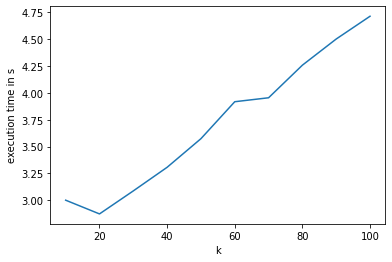

In [ ]:
#@title Plot of average execution time for 10 iterations as a function of rank k
plt.plot(indexes,timeit_results)
plt.xlabel("k")
plt.ylabel("execution time in s")
plt.show()

This will be used as the reference time for the non distributed version of our algorithm.

In the presented Matrix Factorization Algorithm, we will try to distribute 2 main steps :
- First, the step in which we compute the RMSE as there are no other operations at the same time
- Second, the SDE phase.

As we first aim to distribute the computation of **RMSE**, we start by computing the two factorized matrixes $P$ and $Q$ using the non distributed algorithm.

We will use these matrixes $P$ and $Q$ to evaluate the execution time of the distributed **RMSE** function.

In [ ]:
P,Q = mf_sgd(R[:100], k=2, alpha=0.01, beta=0.0001, n_iter=10)

Iteration: 1: RMSE = 3.70876
Iteration: 2: RMSE = 3.67015
Iteration: 3: RMSE = 3.63236
Iteration: 4: RMSE = 3.59509
Iteration: 5: RMSE = 3.55810
Iteration: 6: RMSE = 3.52119
Iteration: 7: RMSE = 3.48419
Iteration: 8: RMSE = 3.44695
Iteration: 9: RMSE = 3.40936
Iteration: 10: RMSE = 3.37133


## RMSE

We can try to distribute the RMSE between the real rating matrix $R$ and the predicted matrix $\hat{R}$ over $l$ cores. **RMSE** is an error defined as a sum of indepedent terms :

RMSE($R,\hat{R}$)$^{2}$=$\sum_{i=0}^{n}(r_{i}-\hat{r}_{i})^{2}$=$\sum_{p=0}^{l-1}\sum_{i=p*[n/l]}^{(p+1)*[n/l]}(r_{i}-\hat{r}_{i})^{2}$

Therefore we also have :

RMSE($R,\hat{R}$)$^{2}$=$\sum_{p=0}^{l-1}\sum_{i=p*[n/l]}^{(p+1)*[n/l]}(r_{i}-\hat{r}_{i})^{2}$

With $l$ a chosen integer.

In [ ]:
%%cython

import numpy as np

cimport cython
cimport numpy as np
np.import_array()

from cython.parallel cimport prange

import array
from cpython cimport array



@cython.boundscheck(False)
@cython.wraparound(False)
cdef double dot_fct(double[:] x,double[:] y) nogil:
  '''Simple dot function as np.dot does not seem to work without gil'''

  cdef int n=len(x)
  cdef int i
  cdef double result=0
  for i in range(n):
    result+=x[i]*y[i]
  return result

@cython.boundscheck(False)
@cython.wraparound(False)
cdef double list_sum(double[:] to_sum_list) nogil:
  '''sum elements in a list'''
  cdef int n = len(to_sum_list)
  cdef double result=0
  for i in range(n):
    result+=to_sum_list[i]
  return result



@cython.boundscheck(False)
@cython.wraparound(False)
def rmse_paral( int[:,:] R, double[:,:] P,  double[:,:] Q,const int n=10) :

    '''Compute root mean square error between  real Rating matrix and predicted rating matrix
    R : sparse rating matrix
    P : First factorization matrix
    Q : second factorization matrix
    n : integer, this is the integer on which we paralellize.
    '''

    cdef int nb_rows=len(R) # Nb of observations
    cdef int step=nb_rows//n # 

    cdef int start_index,end_index

    cdef int k,l
    cdef int i,j,r

    cdef double pred

    cdef double[:] split_error_list=array.array("d",[0 for i in range(n)])

    cdef double tot_error=0
    for k in prange(n-1,nogil=True): # The part in whih the multithreading takes place
      start_index=k*step
      end_index=(k+1)*step if k!=(n-2) else nb_rows
      
      for l in range(start_index,end_index):
        i=R[l,0]
        j=R[l,1]
        r=R[l,2]
        pred=dot_fct(P[i,:],Q[j,:])
        split_error_list[k]+=(r-pred)**2
  
    tot_error=list_sum(split_error_list)
    tot_error=(tot_error/nb_rows)**0.5
    return(tot_error)

#################################################################################################################


@cython.boundscheck(False)
@cython.wraparound(False)
cdef double dot_fct(double[:] x,double[:] y) nogil:
  '''Simple dot function as np.dot does not seem to work without gil'''

  cdef int n=len(x)
  cdef int i
  cdef double result=0
  for i in range(n):
    result+=x[i]*y[i]
  return result

@cython.boundscheck(False)
@cython.wraparound(False)
cdef double list_sum(double[:] to_sum_list) nogil:
  '''sum elements in a list'''
  cdef int n = len(to_sum_list)
  cdef double result=0
  for i in range(n):
    result+=to_sum_list[i]
  return result

@cython.boundscheck(False)
@cython.wraparound(False)

def rmse_non_paral(int[:,:] R, double[:,:] P,  double[:,:] Q) :
    '''Compute root mean square error between real Rating matrix and predicted rating matrix without paralellization
    R : sparse rating matrix
    P : First factorization matrix
    Q : second factorization matrix
    '''
    cdef int nb_rows=len(R)
    cdef int i,j,r

    cdef double pred
    cdef double tot_error=0

    for k in range(nb_rows):
      
      i=R[k,0]
      j=R[k,1]
      r=R[k,2]

      pred=dot_fct(P[i,:],Q[j,:])

      tot_error+=(r-pred)**2
    
    cdef double result=(tot_error/nb_rows)**0.5
    return(result)


When comparing the execution time of the distributed version and the non distributed version of the computation of **RMSE**, we notice that the distributed version is up to 100 times faster :

Distributed version :

In [ ]:
%%timeit
rmse_paral(R[:100],P,Q)

The slowest run took 12.92 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 6.62 µs per loop


Non distributed version :

In [ ]:
%%timeit
rmse(R[:100],P,Q)

1000 loops, best of 5: 735 µs per loop


But it is also important to try and measure the real impact of distributing the computation as once again Cython compiles the code into C++ which makes its execution faster than a normal python distribution anyway.

non distributed Cython RMSE computation  

In [ ]:
%%timeit
rmse_non_paral(R[:100],P,Q)

The slowest run took 14.49 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 5.35 µs per loop


We can notice that the non distributed version Cython version of RMSE is faster than its distributed version (5.35 $\mu$s in average VS 6.62 $\mu$s).

This might come from the fact that we use only a small sample of the rating matrix (10000 ratings). We try again this time using 100000 ratings. But once again, the non distributed version is faster than the distributed version :

In [ ]:
#@title We generate 2 matrixes $P$ and $Q$ of rank 64 using the first 100000 ratings to evaluate the RMSE function
P2,Q2 = mf_sgd(R[:100000], k=64, alpha=0.01, beta=0.0001, n_iter=20) 

Iteration: 2: RMSE = 3.76471
Iteration: 4: RMSE = 3.51983
Iteration: 6: RMSE = 3.21554
Iteration: 8: RMSE = 2.96303
Iteration: 10: RMSE = 2.74403
Iteration: 12: RMSE = 2.54155
Iteration: 14: RMSE = 2.35855
Iteration: 16: RMSE = 2.19591
Iteration: 18: RMSE = 2.05233
Iteration: 20: RMSE = 1.92308


In [ ]:
%%timeit
rmse_paral(R[:100000],P2,Q2)

10 loops, best of 5: 23.7 ms per loop


In [ ]:
%%timeit
rmse_non_paral(R[:100000],P2,Q2)

10 loops, best of 5: 22.4 ms per loop


This might come from the fact that the RMSE function is not complex enough that it is worth to distribute it, therefore it is possible that we lose more time through creating and managing processes than what we win by distributing this function.

## SGD

In this second part, we focus on distributing the SGD part of the algorithm. 

Multiple SGDs can be executed at the same time with no lock, which means that there is a risk of collision when modifying the matrixes $P$ and $Q$, but as the rating matrix is Sparse, and as we randomly pick a rating (associated to a row $i$ and a column $j$) the collision chances are really low.

In [ ]:
%%cython

cimport cython
cimport numpy as np
from cython.parallel cimport prange
from libc.stdlib cimport malloc, free

np.import_array()
from cpython cimport array
import array
import numpy as np

from libc.stdio cimport printf


#Since there seems to be an issue importing rmse_non_paral from __main__, redefine it here
##################################################################

@cython.boundscheck(False)
@cython.wraparound(False)
cdef double dot_fct(double[:] x, double[:] y) nogil:
  '''Simple nogil dot function '''

  cdef int n=len(x)
  cdef int i
  cdef double result=0
  for i in range(n):
    result+=x[i]*y[i]
  return result

@cython.boundscheck(False)
@cython.wraparound(False)
cdef double list_sum(double[:] to_sum_list) nogil:
  '''nogil sum of elements in a list'''
  cdef int n = len(to_sum_list)
  cdef double result=0
  cdef int i
  for i in range(n):
    result+=to_sum_list[i]
  return result

@cython.boundscheck(False)
@cython.wraparound(False)

def rmse_non_paral(int[:,:] R, double[:,:] P,  double[:,:] Q) :
    '''Compute root mean square error between real Rating matrix and predicted rating matrix without paralellization
    R : sparse rating matrix
    P : First factorization matrix
    Q : second factorization matrix
    '''
    cdef int nb_rows=len(R)
    cdef int i,j,r

    cdef double pred
    cdef double tot_error=0

    for k in range(nb_rows):
      
      i=R[k,0]
      j=R[k,1]
      r=R[k,2]

      pred=dot_fct(P[i,:],Q[j,:])

      tot_error+=(r-pred)**2
    
    cdef double result=(tot_error/nb_rows)**0.5
    return(result)



##################################################################

@cython.wraparound(False)
@cython.boundscheck(False)
cdef void error(double *a, double *b, double *c, int* r, int j ) nogil:
  '''
  Function to compute single value prediction error
  double *a : pointer toward first vector
  double *b : pointer toward second vector
  double *c : pointer toward (1,1) array in which scalar product will be stored.
  int j : len of a and b 
  '''
  cdef int k
  for k in range(j):
    c[0]+=a[k]*b[k]
  c[0]=(1.0*r[0])-c[0]

@cython.wraparound(False)
@cython.boundscheck(False)
cdef void update(double *a, double *b, int k, double e, double alpha, double beta) nogil:
  '''Function to update Matrix row during sgd
  double *a : pointer toward row to be updated
  double *b : pointer toward row used from other matrix for prediction
  double *c : pointer toward row in which we store updated value 
  int k : len of a and b
  double e : prediction error
  alpha : parameter
  beta : parameter
  '''
  cdef int i
  for i in range(k):
    a[i]=(1-alpha*beta)*a[i]+alpha*e*b[i]
  




@cython.boundscheck(False)
@cython.wraparound(False)
cdef void sgd_iteration_paral( double[:,:] P,  double[:,:] Q, int[:,:] R, double alpha, double beta, int k):
    """
    SGD iteration over the provided samples from R
    """
    cdef int nb_samples=len(R)
    cdef int l
    cdef double[:,:] stored_errors = np.zeros((nb_samples,1),dtype=float)

    for l in prange(nb_samples,nogil=True):

        error(&P[R[l,0],0], &Q[R[l,1],0], &stored_errors[l,0], &(R[l,2]), k)
        update(&P[R[l,0],0], &Q[R[l,1],0], k, stored_errors[l,0], alpha, beta)
        update(&Q[R[l,1],0], &P[R[l,0],0], k, stored_errors[l,0], alpha, beta)




@cython.boundscheck(False)
@cython.wraparound(False)
def mf_sgd_paral(int[:,:] R, int k, double alpha, double beta, int n_iter, verbose = True):
    """
    Matrix factorization
    - R : matrix to factorize
    - k : latent dimension
    - alpha : learning rate
    - beta : regularization parameter
    - n_iter : number of SGD iterations
    """
    # Initialize user and item feature matrices
    m,n = int(1+np.max(R[:,0])), int(1+np.max(R[:,1]))
    cdef double[:,:] P = 1./k * np.random.normal(size=(m,k))
    cdef double[:,:] Q = 1./k * np.random.normal(size=(n,k))
    cdef int i
    
    # Perform stochastic gradient descent for number of iterations
    for i in range(n_iter):
        sgd_iteration_paral(P, Q, R, alpha, beta, k)
        if verbose and ((i+1)%(n_iter//10) == 0):
            print(f"Iteration: {i+1}: RMSE = {rmse_non_paral(R, np.asarray(P), np.asarray(Q)):.5f}")
    return(np.asarray(P),np.asarray(Q))

In [ ]:
P,Q=mf_sgd_paral(R, k=32, alpha=0.01, beta=0.25, n_iter=50)

Iteration: 5: RMSE = 2.60563
Iteration: 10: RMSE = 1.33964
Iteration: 15: RMSE = 1.02820
Iteration: 20: RMSE = 0.90867
Iteration: 25: RMSE = 0.84722
Iteration: 30: RMSE = 0.80828
Iteration: 35: RMSE = 0.77966
Iteration: 40: RMSE = 0.75641
Iteration: 45: RMSE = 0.73629
Iteration: 50: RMSE = 0.71818


In [ ]:
timeit_results=[]
indexes=[10*i for i in range(1,11)]
number=5
R_time=R[:10000]
for index in indexes:
  exec_time=timeit("mf_sgd_paral(R_time,k="+str(index)+",alpha=0.01, beta=0.25, n_iter=10,verbose=False)","from __main__ import mf_sgd_paral,R_time",number=number)
  exec_time=exec_time/number
  timeit_results.append(exec_time)

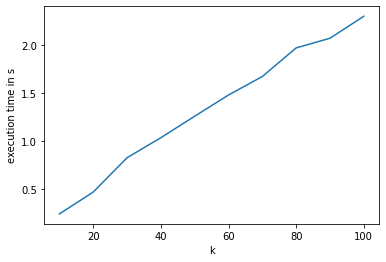

In [ ]:
plt.plot(indexes,timeit_results)
plt.xlabel("k")
plt.ylabel("execution time in s")
plt.show()

We can notice that we win an average speed up of 2 for our Matrix Factorization algorithm using the distributed version (when using the first 10000 ratings).

Below, we do the same but this time using the whole rating matrix :

In [2]:
#Non distributed time with rank 64 for P and Q using the whole matrix R
exec_time=timeit("mf_sgd(R,k=64 ,alpha=0.01, beta=0.25, n_iter=10,verbose=False)","from __main__ import mf_sgd,R",number=1)
print("In average, it took",exec_time,"seconds to execute the program")

In average, it took 353.8863659639974  seconds to execute the program


In [3]:
#Distributed time with rank 64 for P and Q using the whole matrix R
exec_time=timeit("mf_sgd_paral(R,k=64 ,alpha=0.01, beta=0.25, n_iter=10,verbose=False)","from __main__ import mf_sgd_paral,R",number=10)
exec_time=exec_time/10
print("In average, it took",exec_time,"seconds to execute the program")

In average, it took 7.439300606400138  seconds to execute the program


When using the whole matrix (which contains $1.4*10^{6}$ ratings), we find this time that we have a speed up of 47.5. We can hypothesize that a large part of this speed up comes from the fact that we compiled our program to C++ using Cython.